In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, top_k_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == "cuda":
    print(torch.cuda.get_device_name(0))
    print("Memory Usage:")
    print("Allocated:", round(torch.cuda.memory_allocated(0)/1024**3, 1), "GB")
    print("Cached:", round(torch.cuda.memory_reserved(0)/1024**3, 1), "GB")

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

Using device: cpu
tensor([1.], device='mps:0')


In [2]:
def set_seed(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(7598)

In [3]:
from pathlib import Path
import cv2

train_dir = Path(r'../data/train')
test_dir = "../data/test"
val_dir = "../data/val"

files = list(train_dir.rglob('*.png'))

mean = np.array([0.,0.,0.])
stdTemp = np.array([0.,0.,0.])
std = np.array([0.,0.,0.])

numSamples = len(files)

for i in range(numSamples):
    im = cv2.imread(str(files[i]))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = im.astype(float) / 255.
    
    for j in range(3):
        mean[j] += np.mean(im[:,:,j])

mean = (mean/numSamples)

for i in range(numSamples):
    im = cv2.imread(str(files[i]))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = im.astype(float) / 255.
    for j in range(3):
        stdTemp[j] += ((im[:,:,j] - mean[j])**2).sum()/(im.shape[0]*im.shape[1])

std = np.sqrt(stdTemp/numSamples)

print(f"Calculated Mean: {mean}")
print(f"Calculated Standard Deviation: {std}")

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Calculated Mean: [0.49154367 0.49154367 0.49154367]
Calculated Standard Deviation: [0.25023263 0.25023263 0.25023263]


In [4]:
from PIL import Image

batch_size = 64
numworkers = 2

# the below function tranforms and normalises the data

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop((112, 112)),
    # transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize([0.49154367, 0.49154367, 0.49154367], [0.25023263, 0.25023263, 0.25023263])
])

train_dataset = datasets.ImageFolder(train_dir, transform = transform)
test_dataset = datasets.ImageFolder(test_dir, transform = transform)
validation_dataset = datasets.ImageFolder(val_dir, transform = transform)

train_loader = DataLoader(train_dataset, 
                          batch_size = batch_size, 
                          shuffle = True, 
                          num_workers = numworkers)

test_loader = DataLoader(test_dataset, 
                          batch_size = batch_size, 
                          shuffle = False, 
                          num_workers = numworkers)

validation_loader = DataLoader(validation_dataset, 
                          batch_size = batch_size, 
                          shuffle = False, 
                          num_workers = numworkers)

In [12]:
# loading the alexnet model 

model = models.alexnet(weights = models.AlexNet_Weights.IMAGENET1K_V1) # loading a pretrained model
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 15) # changing the output layers to match the number of classes
model = model.to(device)

# loss function and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

### Training 

In [13]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc = "Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    return epoch_loss

In [14]:
def compute_metrics(labels, predictions, probs):
    metrics = {
        "Accuracy" : accuracy_score(labels, predictions),
        "Top-5 Accuracy" : top_k_accuracy_score(labels, probs, k = 5),
        "Macro Precision" : precision_score(labels, predictions, average = "macro"),
        "Weighted Precision" : precision_score(labels, predictions, average = "weighted"),
        "Macro Recall" : recall_score(labels, predictions, average = "macro"), 
        "Weighted Recall" : recall_score(labels, predictions, average = "weighted"), 
        "Weighted F1-Score" : f1_score(labels, predictions, average = "weighted"),
        "Weighted AUC Score" : roc_auc_score(labels, probs, multi_class = "ovr", average = "weighted"),
        "Weighted Mean Average Precision" : average_precision_score(labels, probs, average = "weighted")
    }
    
    return metrics

In [15]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc = "Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(nn.Softmax(dim = 1)(outputs).cpu().numpy())

    epoch_loss = running_loss / len(data_loader.dataset)
    accuracy = 100 * correct / total

    metrics = compute_metrics(all_labels, all_predictions, all_probs)

    return epoch_loss, accuracy, metrics

In [16]:
from typing import Any

class EarlyStopping:
    def __init__(self, patience = 5, verbose = False, delta = 0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None 
        self.early_stop = False
        self.counter = 0
        self.best_loss = None 

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            if self.best_loss is not None:
                print(f"Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}). Saving model ...")
            else:
                print(f"Saving model with validation loss {val_loss:.6f} ...")
        torch.save(model.state_dict(), "best_model.pth")
        self.best_loss = val_loss

Actually Training

In [17]:
num_epochs = 1
patience = 5
early_stopping = EarlyStopping(patience = patience, verbose = True)

train_losses = []
val_losses = []
val_accuracies = []
metrics_list = []

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, metrics = evaluate(model, validation_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    metrics_list.append(metrics)

    print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name} : {metric_value:.4f}")
    
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

Training:   0%|          | 0/1554 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/207 [00:00<?, ?it/s]

/Users/coding/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/coding/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 1/1, Train Loss: 2.0120, Val Loss: 1.9948, Val Accuracy: 4227.69%
Accuracy : 0.4228
Top-5 Accuracy : 0.7747
Macro Precision : 0.0282
Weighted Precision : 0.1787
Macro Recall : 0.0667
Weighted Recall : 0.4228
Weighted F1-Score : 0.2512
Weighted AUC Score : 0.5000
Weighted Mean Average Precision : 0.2226
Saving model with validation loss 1.994846 ...


### Evaluation

In [18]:
metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv("metrics.csv", index = False)

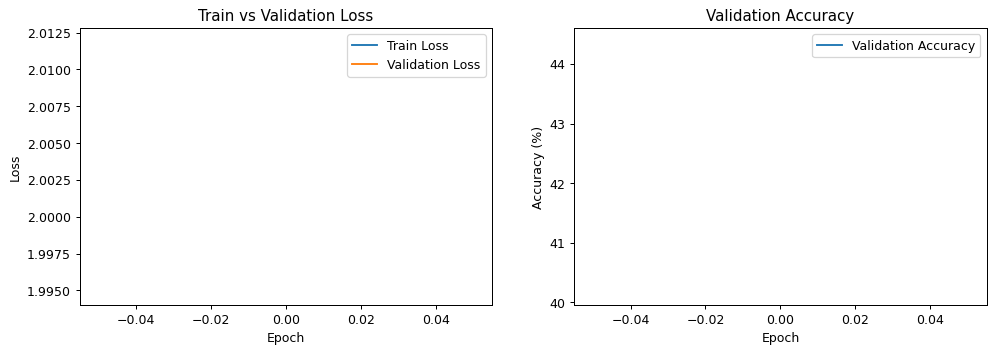

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize = (13, 4), dpi = 90)
plt.subplot(1, 2, 1)
plt.plot(train_losses, label = "Train Loss")
plt.plot(val_losses, label = "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label = "Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.legend()

plt.show()

In [20]:
test_loss, test_accuracy, test_metrics = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
for metric_name, metric_value in test_metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

Evaluating:   0%|          | 0/311 [00:00<?, ?it/s]

In [ ]:
def get_all_predictions(loader, model, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.view(-1).tolist())
            all_labels.extend(labels.view(-1).tolist())
    return all_preds, all_labels

train_preds, train_labels = get_all_predictions(train_loader, model, device)
val_preds, val_labels = get_all_predictions(validation_loader, model, device)
test_preds, test_labels = get_all_predictions(test_loader, model, device)

### Confusion Matrix

In [ ]:
# import torch
# import torch.nn as nn
# from torchvision import models
# from sklearn.metrics import confusion_matrix
# import numpy as np
# import matplotlib.pyplot as plt

# train_cm = confusion_matrix(train_labels, train_preds)
# val_cm = confusion_matrix(val_labels, val_preds)
# test_cm = confusion_matrix(test_labels, test_preds)

# def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
#     plt.figure(figsize=(8, 6))
#     plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.show()

# plot_confusion_matrix(train_cm, dataset_classes, title='Training Confusion Matrix')
# plot_confusion_matrix(val_cm, dataset_classes, title='Validation Confusion Matrix')
# plot_confusion_matrix(test_cm, dataset_classes, title='Test Confusion Matrix')


### Viewing Model's Mistakes

In [ ]:
def display_random_images(model, test_dataset, dataset_classes, num_images = 12):
    model.eval()
    indices = random.sample(range(len(test_dataset)), num_images)
    images, labels = zip(*[test_dataset[i] for i in indices])
    images = torch.stack(images).to(device)
    labels = torch.tensor(labels).to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    images = images.cpu().numpy().transpose((0, 2, 3, 1))
    images = images * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    images = np.clip(images, 0, 1)

    fig, axes = plt.subplots(4, 3, figsize = (12, 12))
    axes = axes.flatten()
    for img, true_label, pred_label, ax in zip(images, labels, predicted, axes):
        ax.imshow(img)
        ax.set_title(f"True: {dataset_classes[true_label]} \nPred: {dataset_classes[pred_label]}", color = '#009878' if true_label == pred_label else "#9C3839")
        ax.axis("off")

    plt.tight_layout()
    # plt.savefig("output_images/alexnet_test_images.jpg", dpi = 300)
    plt.show()

In [ ]:
display_random_images(model, test_dataset, test_dataset.classes)
